In [1]:
import os
import math
import gc
import tensorflow as tf
import numpy as np
import matplotlib as matplt
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy import signal
from scipy.io import wavfile
from scipy import interpolate
from scipy.fftpack import fft, rfft

In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)

gc.enable()

## Set path variables

In [3]:
train_path = './train_1/'
train_path_one = './train_1/one/'
train_path_two = './train_1/two/'

In [4]:
os.listdir(train_path_one)

['ch3', 'ch2', 'ch1', 'ch4']

In [5]:
os.listdir(train_path_two)

['ch3', 'ch2', 'ch1', 'ch4']

In [6]:
train_dict_one = defaultdict(list)

for folder in os.listdir(train_path_one):
    train_dict_one[folder] = os.listdir(train_path_one + '/' + folder)
    
train_dict_two = defaultdict(list)

for folder in os.listdir(train_path_two):
    train_dict_two[folder] = os.listdir(train_path_two + '/' + folder)

## Log spectogram function

In [7]:
def log_spectrogram(wav,
                    sample_rate=8000,
                    crop=None,
                    nfft=None,
                    nperseg=2048,
                    noverlap=None,
                    eps=1e-10,
                    spec_only=True):
    
    freqs, times, spectro = signal.spectrogram(wav,
                                               fs=sample_rate,
                                               window='hann',
                                               noverlap=noverlap,
                                               nperseg=nperseg,
                                               nfft=nfft,
                                               detrend=False)
    
    if spec_only:
        return np.log(spectro.astype(np.float32) + eps)
    else:
        return freqs, times, np.log(spectro.astype(np.float32) + eps)

## Plot functions

In [8]:
# input = wav file path

def plot_log_spec(file_path, crop=None):

    sr, wav = wavfile.read(file_path)
        
    if crop != None:
        wav = wav[:crop]
    
    f = interpolate.interp1d(np.arange(wav.shape[0]), wav)
    iwav = f(np.arange(0, wav.shape[0] - 1, 0.01))

    spec = log_spectrogram(iwav,
                           sr,
                           nperseg=2048,
                           nfft=None,
                           noverlap=None,
                           crop=crop,
                           spec_only=True)

    print(spec.shape)
    plt.figure(figsize=(15,5))
    plt.imshow(spec, origin='lower', extent=[0, len(iwav) / sr, 0, sr], aspect='auto')
    
def plot_wavelet(file_path, crop=None):
    
    sr, wav = wavfile.read(file_path)
    
    if crop != None:
        wav = wav[:crop]
    
    plt.figure(figsize=(15,3))
    plt.plot(np.arange(0, wav.shape[0]), wav)

## Square transform function

In [9]:
# transform wavelets to square form

def square_transform(wav, window=10, peak_width=1000, boost=1000):

    signal_peaks = []

    for i in range(window, len(wav) - window, window):

        if wav[i - window] <= wav[i] >= wav[i + window]:
            signal_peaks.append((wav[i], i))
        elif wav[i - window] >= wav[i] <= wav[i + window]:
            signal_peaks.append((wav[i], i))

    samples = wav
    mean_sample_value = np.mean(samples)
    
    time_peaks = [x for (y, x) in signal_peaks]
    peaks = [y for (y, x) in signal_peaks]

    square_wav = []
    width_counter = 0
    current_peak = 0
    peak_counter = 0

    for sample_counter in range(len(samples) - 1):

        if sample_counter in time_peaks and peak_counter < len(peaks) - 1:

            if peaks[peak_counter + 1] < peaks[peak_counter]:
                current_peak = samples[sample_counter] - mean_sample_value + boost
            else:
                current_peak = samples[sample_counter] - mean_sample_value - boost

            square_wav.append(current_peak)
            peak_counter += 1
            width_counter = 0

        else:

            if peak_width > 1:
                square_wav.append(current_peak)

                if current_peak:
                    width_counter = (width_counter + 1) % peak_width
                if not width_counter:
                    current_peak = 0

            else:
                square_wav.append(0)

    return np.array(square_wav)

## Angle function

In [10]:
def phase_angle(wav, window = 500):

    angles = []

    chunks = [wav[i: i + window] for i in range(0, len(wav), window)]

    for chunk in chunks:
        angles.append(np.angle(fft(chunk)))

    angles = np.concatenate(angles)

    return angles

##    Tune log spectogram function

(100, 456)


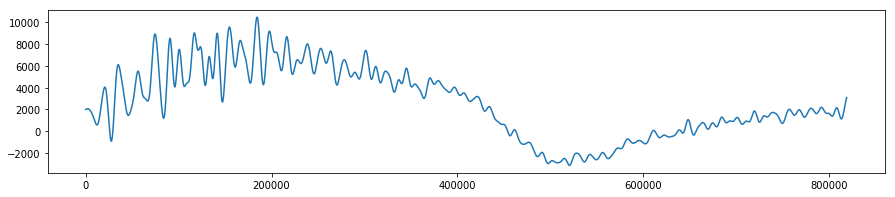

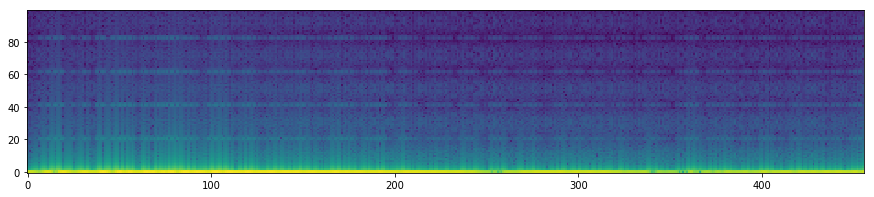

In [11]:
# sr: sample rate
# wav: samples

sr, wav = wavfile.read(train_path_one + 'ch2/' + train_dict_one['ch3'][6])

# increase sampling rate x100 using interpolation
f = interpolate.interp1d(np.arange(wav.shape[0]), wav)
iwav = f(np.arange(0, wav.shape[0] - 1, 0.01))

# plot wavelet
plt.figure(figsize=(15,3))
plt.plot(np.arange(0, iwav.shape[0]), iwav)

# get spectogram
spec = log_spectrogram(iwav,
                       sr,
                       nperseg=2048,
                       nfft=None,
                       noverlap=None,
                       spec_only=True)

# plot cropped spectogram
spec = spec[:100,:]
print(spec.shape)
plt.figure(figsize=(15,3))
plt.imshow(spec, origin='lower', aspect='auto')

##    Tune square transform function

In [12]:
# get peaks
# get min and max peaks per sec

signal_peaks_list = []
signal_list = []
peaks_per_sec = dict()

# size of window in samples
window = 10

for folder in train_dict_one:
    
    for file in train_dict_one[folder]:
        
        fs, samples = wavfile.read(os.path.join(train_path_one, folder, file))
        
        signal_list.append(samples)
        prev = samples[0]
        
        signal_peaks = []
        
        for i in range(window, len(samples) - window, window):
            
            if samples[i - window] <= samples[i] >= samples[i + window]:
                signal_peaks.append((samples[i], i))
            elif samples[i - window] >= samples[i] <= samples[i + window]:
                signal_peaks.append((samples[i], i))
            
        signal_peaks_list.append(signal_peaks)
        peaks_per_sec.update({train_path_one + folder + '/' + file: len(signal_peaks) / (len(samples) / fs)})

min_tuple = min([(y, x) for (x, y) in peaks_per_sec.items()])
max_tuple = max([(y, x) for (x, y) in peaks_per_sec.items()])

print('min:', min_tuple)
print('max:', max_tuple)

#plot_wavelet(min_tuple[1])
#plot_wavelet(max_tuple[1])

min: (110.67708333333333, './train_1/one/ch4/00026.wav')
max: (159.1796875, './train_1/one/ch1/00945.wav')


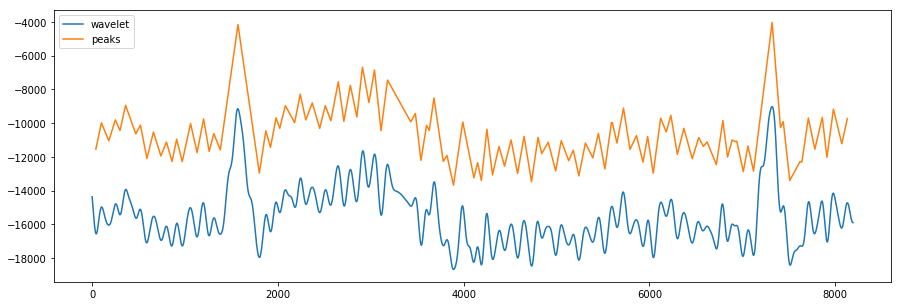

In [13]:
# plot peaks

shift_peaks = 5e3

plt.figure(figsize=(15,5))
plt.plot(signal_list[2000])
plt.plot([x for (y, x) in signal_peaks_list[2000]], [y + shift_peaks for (y, x) in signal_peaks_list[2000]])
plt.legend(['wavelet', 'peaks'], loc='upper left')

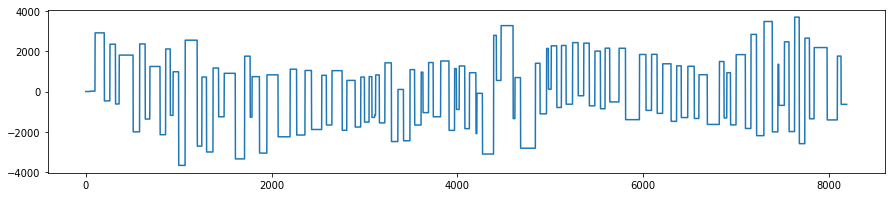

(100, 456)


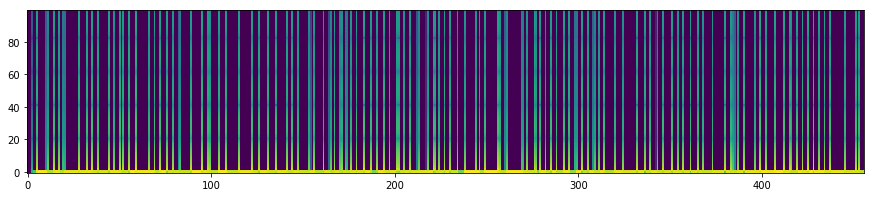

In [14]:
# get random signal
# remove DC offset
# boost peak values and get spectogram
# setting large PEAK_WIDTH enables square waveforms

random_sample = np.random.randint(0, len(signal_list))

samples = signal_list[random_sample]
time_peaks = [x for (y, x) in signal_peaks_list[random_sample]]
peaks = [y for (y, x) in signal_peaks_list[random_sample]]

BOOST = 1000
PEAK_WIDTH = 500
MEAN_SAMPLE_VALUE = np.mean(samples)

new = []
width_counter = 0
current_peak = 0
peak_counter = 0

for sample_counter in range(len(samples) - 1):
    
    if sample_counter in time_peaks and peak_counter < len(peaks) - 1:
        
        if peaks[peak_counter + 1] < peaks[peak_counter]:
            current_peak = samples[sample_counter] - MEAN_SAMPLE_VALUE + BOOST
        else:
            current_peak = samples[sample_counter] - MEAN_SAMPLE_VALUE - BOOST
            
        new.append(current_peak)
        peak_counter += 1
        width_counter = 0
        
    else:
        
        if PEAK_WIDTH > 1:
            new.append(current_peak)
            
            if current_peak:
                width_counter = (width_counter + 1) % PEAK_WIDTH
            if not width_counter:
                current_peak = 0
                
        else:
            new.append(0)
        

plt.figure(figsize=(15,3))
plt.plot(new)
plt.show()

wav = np.array(new)

f = interpolate.interp1d(np.arange(wav.shape[0]), wav)
iwav = f(np.arange(0, wav.shape[0] - 1, 0.01))

spec = log_spectrogram(iwav)
spec = spec[:100,:]
print(spec.shape)

plt.figure(figsize=(15,3))
plt.imshow(spec, origin='lower', aspect='auto')

##    Tune phase angle function

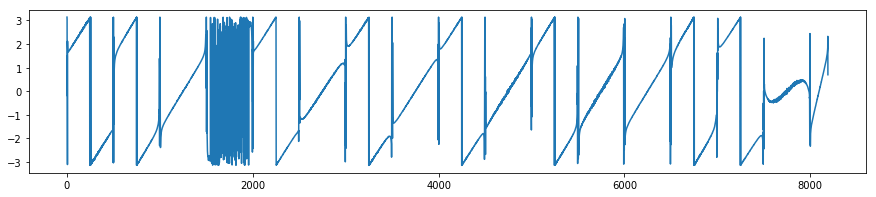

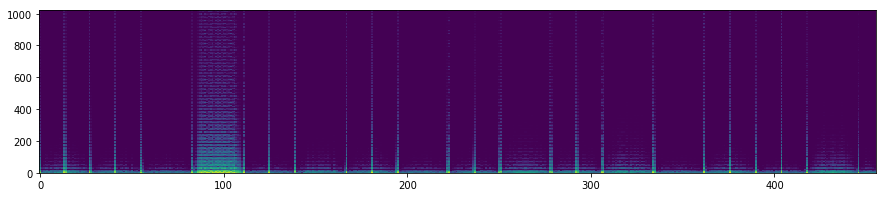

In [15]:
# get approximated phase angles
# step is set to 1
# overlap = window - step

random_sample = np.random.randint(0, len(signal_list))
wav = signal_list[random_sample]

angles = []
window = 500

# split signal
chunks = [wav[i: i + window] for i in range(0, len(wav), window)]

# calculate fft and then phase angle
for chunk in chunks:
    angles.append(np.angle(fft(chunk)))

# plot angles
angles = np.concatenate(angles)
plt.figure(figsize=(15,3))
plt.plot(angles)

# increase sample rate
f = interpolate.interp1d(np.arange(angles.shape[0]), angles)
iwav = f(np.arange(0, angles.shape[0] - 1, 0.01))

# plot spectogram for angle samples
plt.figure(figsize=(15,3))
plt.imshow(log_spectrogram(iwav), origin='lower', aspect='auto')

In [ ]:
random_sample = np.random.randint(0, len(signal_list))
wav = signal_list[random_sample]

angles = []
window = 0

for window in range(0)
chunks = [wav[i: i + window] for i in range(0, len(wav), window)]

for chunk in chunks:
    angles.append(np.angle(fft(chunk)))

## Check outliers in label 1

In [10]:
# get min and max file sizes

file_sizes = []

for folder in train_dict_one:
    for file in train_dict_one[folder]:
        file_sizes.append(os.stat(os.path.join(train_path_one, folder, file)).st_size)

print('min:', min(file_sizes) / 1000, 'kb')
print('max:', max(file_sizes) / 1000, 'kb')

min: 12.402 kb
max: 20.594 kb


In [11]:
# get min and max for number of samples and sampling frequency

wav_samples = []
wav_sample_rates = []

for folder in train_dict_one:
    for file in train_dict_one[folder]:
        fs, s = wavfile.read(os.path.join(train_path_one, folder, file))
        wav_samples.append(len(s))
        wav_sample_rates.append(fs)

print('min:', min(wav_samples), 'samples')
print('max:', max(wav_samples), 'samples', end='\n\n')

print('min:', min(wav_sample_rates), 'hz')
print('max:', max(wav_sample_rates), 'hz')

MIN_SAMPLES_ONE = min(wav_samples)

min: 6144 samples
max: 10240 samples

min: 8000 hz
max: 8000 hz


In [12]:
# get min and max stddev

stddev_list = dict()

for folder in train_dict_one:
    
    for file in train_dict_one[folder]:
        
        fs, samples = wavfile.read(os.path.join(train_path_one, folder, file))
        
        stddev_list.update({train_path_one + folder + '/' + file: np.std(samples, axis=0)})
        
min_tuple = min([(y, x) for (x, y) in stddev_list.items()])
max_tuple = max([(y, x) for (x, y) in stddev_list.items()])

print('min:', min_tuple)
print('max:', max_tuple)

#plot_wavelet(min_tuple[1])
#plot_wavelet(max_tuple[1])

min: (220.82204867816998, './train_1/one/ch2/00000.wav')
max: (7892.0338008023955, './train_1/one/ch4/00655.wav')


In [13]:
# init outlier list

outlier_list = []

total: 1017
samples: 47


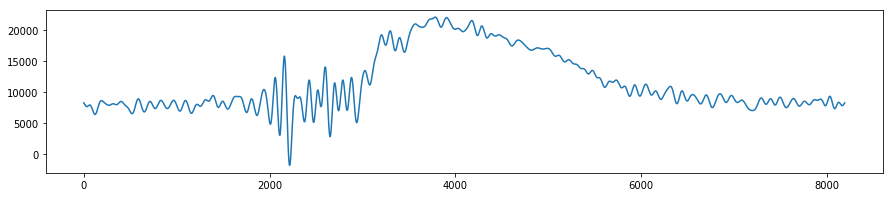

In [14]:
# check stddev for channel_1 signals in more detail
# get signals with stddev higher than threshold and plot few of them

thres = 3000
folder = 'ch1'
stddev_list = dict()

for file in train_dict_one[folder]:

    fs, samples = wavfile.read(os.path.join(train_path_one, folder, file))
    
    if np.std(samples, axis=0) > thres:
        stddev_list.update({train_path_one + folder + '/' + file: np.std(samples, axis=0)})

print('total:', len(train_dict_one[folder]))
print('samples:', len(stddev_list.keys()))

count = 0
for file_path, stddev in stddev_list.items():
    count += 1
    if count > 1:
        break
    plot_wavelet(file_path)

In [15]:
# add outliers to list

outlier_list.extend(stddev_list.keys())

total: 1017
samples: 54


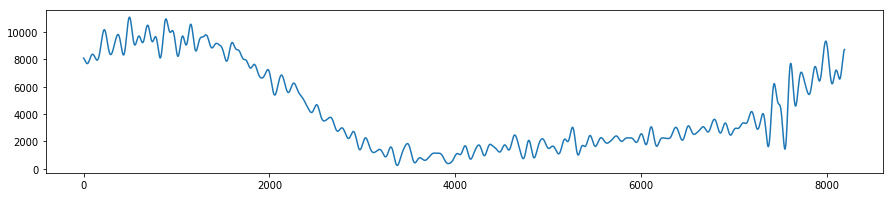

In [16]:
# check stddev for channel_2 signals in more detail
# get signals with stddev higher than threshold and plot few of them

thres = 3000
folder = 'ch2'
stddev_list = dict()

for file in train_dict_one[folder]:

    fs, samples = wavfile.read(os.path.join(train_path_one, folder, file))
    
    if np.std(samples, axis=0) > thres:
        stddev_list.update({train_path_one + folder + '/' + file: np.std(samples, axis=0)})

print('total:', len(train_dict_one[folder]))
print('samples:', len(stddev_list.keys()))

count = 0
for file_path, stddev in stddev_list.items():
    count += 1
    if count > 1:
        break
    plot_wavelet(file_path)

In [17]:
# add outliers to list

outlier_list.extend(stddev_list.keys())

total: 1017
samples: 14


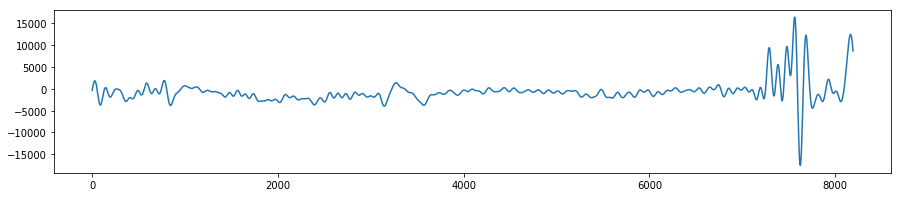

In [18]:
# check stddev for channel_3 signals in more detail
# get signals with stddev higher than threshold and plot few of them

thres = 2500
folder = 'ch3'
stddev_list = dict()

for file in train_dict_one[folder]:

    fs, samples = wavfile.read(os.path.join(train_path_one, folder, file))
    
    if np.std(samples, axis=0) > thres:
        stddev_list.update({train_path_one + folder + '/' + file: np.std(samples, axis=0)})

print('total:', len(train_dict_one[folder]))
print('samples:', len(stddev_list.keys()))

count = 0
for file_path, stddev in stddev_list.items():
    count += 1
    if count > 1:
        break
    plot_wavelet(file_path)

In [19]:
# add outliers to list

outlier_list.extend(stddev_list.keys())

total: 1017
samples: 9


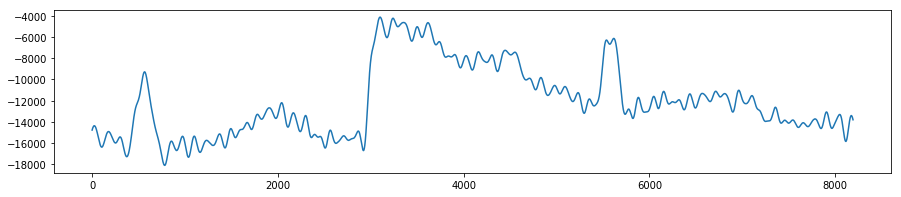

In [20]:
# check stddev for channel_4 signals in more detail
# get signals with stddev higher than threshold and plot few of them

thres = 3000
folder = 'ch4'
stddev_list = dict()

for file in train_dict_one[folder]:

    fs, samples = wavfile.read(os.path.join(train_path_one, folder, file))
    
    if np.std(samples, axis=0) > thres:
        stddev_list.update({train_path_one + folder + '/' + file: np.std(samples, axis=0)})

print('total:', len(train_dict_one[folder]))
print('samples:', len(stddev_list.keys()))

count = 0
for file_path, stddev in stddev_list.items():
    count += 1
    if count > 1:
        break
    plot_wavelet(file_path)

In [21]:
# add outliers to list

outlier_list.extend(stddev_list.keys())

In [22]:
# get total number of outliers

outliers = [file_path.split(sep='/')[-1] for file_path in outlier_list]
outliers_one = set(outliers)
len(outliers_one)

114

## Check outliers in label 2

In [23]:
# get min and max file sizes

file_sizes = []

for folder in train_dict_two:
    for file in train_dict_two[folder]:
        file_sizes.append(os.stat(os.path.join(train_path_two, folder, file)).st_size)

print('min:', min(file_sizes) / 1000, 'kb')
print('max:', max(file_sizes) / 1000, 'kb')

min: 12.402 kb
max: 20.594 kb


In [24]:
# get min and max for number of samples and sampling frequency

wav_samples = []
wav_sample_rates = []

for folder in train_dict_two:
    for file in train_dict_two[folder]:
        fs, s = wavfile.read(os.path.join(train_path_two, folder, file))
        wav_samples.append(len(s))
        wav_sample_rates.append(fs)

print('min:', min(wav_samples), 'samples')
print('max:', max(wav_samples), 'samples', end='\n\n')

print('min:', min(wav_sample_rates), 'hz')
print('max:', max(wav_sample_rates), 'hz')

MIN_SAMPLES_TWO = min(wav_samples)

min: 6144 samples
max: 10240 samples

min: 8000 hz
max: 8000 hz


In [25]:
# get min and max stddev
# it seems there are unwanted artefacts in some of the signals

stddev_list = dict()

for folder in train_dict_two:
    
    for file in train_dict_two[folder]:
        
        fs, samples = wavfile.read(os.path.join(train_path_two, folder, file))
        
        stddev_list.update({train_path_two + folder + '/' + file: np.std(samples, axis=0)})
        
min_tuple = min([(y, x) for (x, y) in stddev_list.items()])
max_tuple = max([(y, x) for (x, y) in stddev_list.items()])

print('min:', min_tuple)
print('max:', max_tuple)

#plot_wavelet(min_tuple[1])
#plot_wavelet(max_tuple[1])

min: (224.9007202491352, './train_1/two/ch2/00003.wav')
max: (7304.346179002157, './train_1/two/ch1/00756.wav')


In [26]:
# init outlier list

outlier_list = []

total: 1017
samples: 21


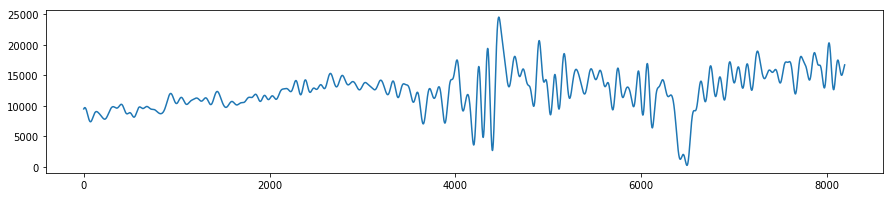

In [27]:
# check stddev for channel_1 signals in more detail
# get signals with stddev higher than threshold and plot few of them

thres = 3000
folder = 'ch1'
stddev_list = dict()

for file in train_dict_two[folder]:

    fs, samples = wavfile.read(os.path.join(train_path_two, folder, file))
    
    if np.std(samples, axis=0) > thres:
        stddev_list.update({train_path_two + folder + '/' + file: np.std(samples, axis=0)})

print('total:', len(train_dict_two[folder]))
print('samples:', len(stddev_list.keys()))

count = 0
for file_path, stddev in stddev_list.items():
    count += 1
    if count > 1:
        break
    plot_wavelet(file_path)

In [28]:
# add outliers to list

outlier_list.extend(stddev_list.keys())

total: 1017
samples: 61


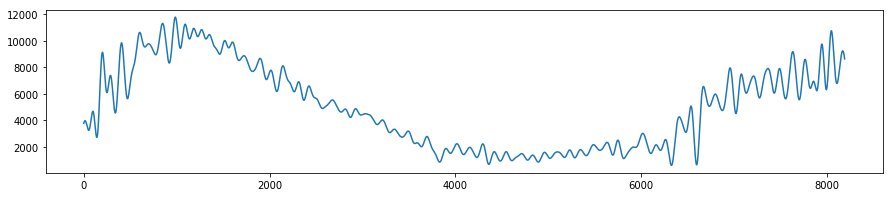

In [29]:
# check stddev for channel_2 signals in more detail
# get signals with stddev higher than threshold and plot few of them

thres = 3000
folder = 'ch2'
stddev_list = dict()

for file in train_dict_two[folder]:

    fs, samples = wavfile.read(os.path.join(train_path_two, folder, file))
    
    if np.std(samples, axis=0) > thres:
        stddev_list.update({train_path_two + folder + '/' + file: np.std(samples, axis=0)})

print('total:', len(train_dict_two[folder]))
print('samples:', len(stddev_list.keys()))

count = 0
for file_path, stddev in stddev_list.items():
    count += 1
    if count > 1:
        break
    plot_wavelet(file_path)

In [30]:
# add outliers to list

outlier_list.extend(stddev_list.keys())

total: 1017
samples: 14


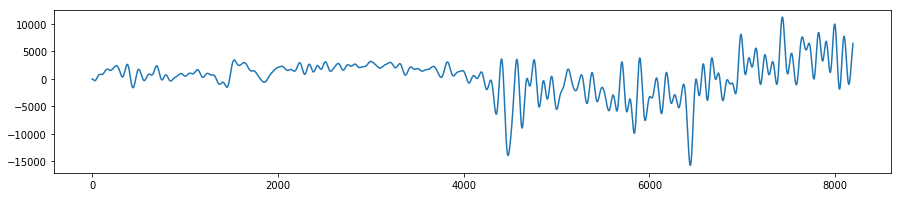

In [31]:
# check stddev for channel_3 signals in more detail
# get signals with stddev higher than threshold and plot few of them

thres = 3000
folder = 'ch3'
stddev_list = dict()

for file in train_dict_two[folder]:

    fs, samples = wavfile.read(os.path.join(train_path_two, folder, file))
    
    if np.std(samples, axis=0) > thres:
        stddev_list.update({train_path_two + folder + '/' + file: np.std(samples, axis=0)})

print('total:', len(train_dict_two[folder]))
print('samples:', len(stddev_list.keys()))

count = 0
for file_path, stddev in stddev_list.items():
    count += 1
    if count > 1:
        break
    plot_wavelet(file_path)

In [32]:
# add outliers to list

outlier_list.extend(stddev_list.keys())

total: 1017
samples: 14


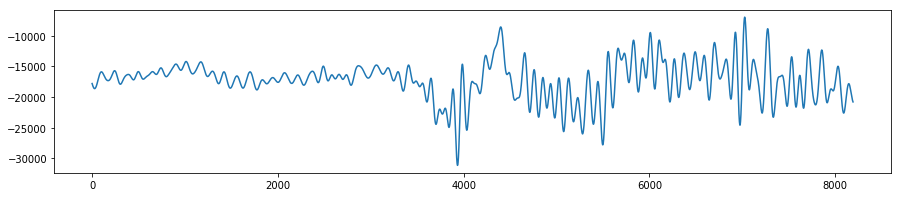

In [33]:
# check stddev for channel_4 signals in more detail
# get signals with stddev higher than threshold and plot few of them

thres = 3000
folder = 'ch4'
stddev_list = dict()

for file in train_dict_two[folder]:

    fs, samples = wavfile.read(os.path.join(train_path_two, folder, file))
    
    if np.std(samples, axis=0) > thres:
        stddev_list.update({train_path_two + folder + '/' + file: np.std(samples, axis=0)})

print('total:', len(train_dict_two[folder]))
print('samples:', len(stddev_list.keys()))

count = 0
for file_path, stddev in stddev_list.items():
    count += 1
    if count > 1:
        break
    plot_wavelet(file_path)

In [34]:
# add outliers to list

outlier_list.extend(stddev_list.keys())

In [35]:
# get total number of outliers

outliers = [file_path.split(sep='/')[-1] for file_path in outlier_list]
outliers_two = set(outliers)
len(outliers_two)

88

In [36]:
# compare outliers in labels and get uniques

outliers = outliers_one | outliers_two
len(outliers)

172

## Get train data

In [185]:
# get 4 cooresponding samples from 4 different channels
# create 4 specs
# crop specs horizontally and concatenate them

def get_train_data(samples=None):
    
    np_wav_list = []
    labels = []

    for label in ['one', 'two']:
        
        i = 0
        for file_name in train_dict_one['ch1']:
            
            if samples != None:
                if i >= samples:
                    continue
                i += 1

            file = file_name.split(sep='/')[-1]

            specs = []
            #specs_2 = []

            if file not in outliers:

                labels.append(label)

                for folder in os.listdir(train_path_one):

                    fs, wav = wavfile.read(os.path.join(train_path, label, folder, file))
                    
                    # get spectograms
                    wav = wav[:MIN_SAMPLES_ONE]
                    f = interpolate.interp1d(np.arange(wav.shape[0]), wav)
                    iwav = f(np.arange(0, wav.shape[0] - 1, 0.01))
                    specs.append(log_spectrogram(iwav)[:100,:])
                    
                    # get angle spectograms
                    #angles = phase_angle(wav)
                    #f = interpolate.interp1d(np.arange(angles.shape[0]), angles)
                    #iwav = f(np.arange(0, angles.shape[0] - 1, 0.01))
                    #specs_2.append(log_spectrogram(iwav)[:50,:])
                
                # concatenate 8 cropped spectograms
                #stack = np.concatenate([*specs, *specs_2], axis=0)
                stack = np.concatenate(specs, axis=0)

                np_wav_list.append(stack)
    
    # concatenate all numpy examples
    np_examples = np.stack(np_wav_list, axis=0)
    
    # enumerate labels
    enum_dict = {'one' : 0, 'two': 1}

    num_labels = [enum_dict[label] for label in labels]
    np_labels = np.array(num_labels, dtype=int)
    
    return np_examples, np_labels

In [186]:
# get numpy train data and labels

np_examples, np_labels = get_train_data(samples=None)

In [187]:
np_examples[0].shape

(400, 342)

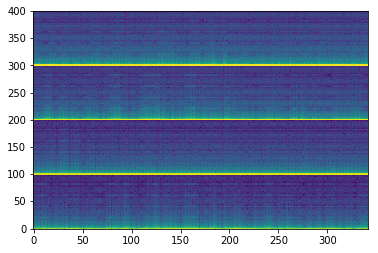

In [188]:
plt.imshow(np_examples[0], origin='lower', aspect='auto')

In [189]:
np_examples = np.expand_dims(np_examples, axis=3)

In [190]:
# check array size

print('array size is {:.2f} gb'.format(np_examples.size * np_examples.itemsize / 1024 ** 3))

array size is 0.86 gb


In [191]:
# shuffle data

arr = np.arange(0, np_examples.shape[0], dtype=int)
np.random.shuffle(arr)

np_examples = np_examples[arr]
np_labels = np_labels[arr]

In [192]:
# split data

RATIO = 0.8

size = round(np_examples.shape[0] * RATIO)

train_examples = np_examples[:size]
train_labels = np_labels[:size]

valid_examples = np_examples[size:]
valid_labels = np_labels[size:]

In [193]:
print(train_examples.shape)
print(train_labels.shape)
print(valid_examples.shape)
print(valid_labels.shape)

(1352, 400, 342, 1)
(1352,)
(338, 400, 342, 1)
(338,)


In [194]:
#plt.figure(figsize=(15,3))
#plt.imshow(train_examples[9], aspect='auto')

## Model

In [195]:
def cnn_model_fn(features, labels, mode, params):
    
    conv_layer_1 = tf.layers.conv2d(
        inputs=features['x'],
        filters=8,
        kernel_size=[2, 2],
        strides=1,
        padding='valid',
        activation=tf.nn.relu)
    
    conv_layer_2 = tf.layers.conv2d(
        inputs=conv_layer_1,
        filters=16,
        kernel_size=[2, 2],
        strides=[2, 2],
        padding='same',
        activation=tf.nn.relu)
    
    pool_layer_1 = tf.layers.average_pooling2d(
        inputs=conv_layer_2,
        pool_size=[2, 2],
        strides=2)
    
    conv_layer_3 = tf.layers.conv2d(
        inputs=pool_layer_1,
        filters=32,
        kernel_size=[2, 2],
        strides=2,
        padding='same',
        activation=tf.nn.relu)

    conv_layer_4 = tf.layers.conv2d(
        inputs=conv_layer_3,
        filters=64,
        kernel_size=[2, 2],
        strides=2,
        padding='same',
        activation=tf.nn.relu)
    
    pool_layer_2 = tf.layers.average_pooling2d(
        inputs=conv_layer_4,
        pool_size=[2, 2],
        strides=2)
    
    conv_layer_5 = tf.layers.conv2d(
        inputs=pool_layer_2,
        filters=128,
        kernel_size=[2, 2],
        strides=1,
        padding='same',
        activation=tf.nn.relu)

    conv_layer_6 = tf.layers.conv2d(
        inputs=conv_layer_5,
        filters=256,
        kernel_size=[2, 2],
        strides=2,
        padding='same',
        activation=tf.nn.relu)
    
    pool_layer_3 = tf.layers.max_pooling2d(
        inputs=conv_layer_6,
        pool_size=[2, 2],
        strides=2)
    
    reshape_layer = tf.layers.flatten(
        pool_layer_3)
    
    dense_layer_1 = tf.layers.dense(
        inputs=reshape_layer,
        units=1024,
        activation=tf.nn.relu)
    
    is_train = False
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        is_train = True
    
    dropout_layer = tf.layers.dropout(
        inputs=dense_layer_1,
        rate=0.2,
        training=is_train)
    
    logits_layer = tf.layers.dense(
        inputs=dropout_layer,
        units=NUM_CLASSES)
    
    classes = tf.argmax(
        input=logits_layer,
        axis=1)
    
    probs = tf.nn.softmax(
        logits_layer, axis=1)
    
    predictions = {
        'classes': classes,
        'probabilities': probs}
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    loss = tf.losses.sparse_softmax_cross_entropy(
        labels=labels,
        logits=probs)
    
    accuracy = tf.metrics.accuracy(
        labels=labels,
        predictions=tf.argmax(probs, axis=1),
        name='acc')
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        train_optimizer = tf.train.AdamOptimizer(params['learning_rate']).minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_optimizer)
    
    # mode = EVAL
    eval_metric_ops = {'acc':accuracy}
    
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

## Train function

In [196]:
def train_and_evaluate(estimator, steps=10, epochs=1):

    all_train_log = []
    all_validate_log = []
    
    for _ in range(epochs):
        
        for step in range(steps):
            
            estimator.train(input_fn=train_input_fn)
            
            train_log = estimator.evaluate(input_fn=eval_input_fn)
            print('STEP: {} of {}'.format(step + 1, steps))
            print('TRAIN: acc={:.3f} loss={:.3f}'.format(train_log['acc'], train_log['loss']))
            
            validate_log = estimator.evaluate(input_fn=validate_input_fn)
            print('VALID: acc={:.3f} loss={:.3f}'.format(validate_log['acc'], validate_log['loss']))
            
            all_train_log.append(train_log)
            all_validate_log.append(validate_log)
            
    return all_train_log, all_validate_log

## Train

In [197]:
# init logs

all_train_log = []
all_validate_log = []

In [201]:
# HYPERS

gc.collect()

NUM_CLASSES = 2
LEARN_RATE = 0.0001
BATCH_SIZE = 30
STEPS = 5
OUTDIR = './subvoc_4_train_data'


# INPUT FUNCTIONS

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':train_examples},
    y=train_labels,
    batch_size=BATCH_SIZE,
    num_epochs=1,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':train_examples},
    y=train_labels,
    batch_size=BATCH_SIZE,
    num_epochs=1,
    shuffle=False)

validate_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':valid_examples},
    y=valid_labels,
    batch_size=BATCH_SIZE,
    num_epochs=1,
    shuffle=False)


# ESTIMATOR

cnn_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn,
    model_dir=OUTDIR,
    params={'batch_size':BATCH_SIZE,
           'learning_rate':LEARN_RATE})


# TRAIN

train_log, validate_log = train_and_evaluate(cnn_classifier, steps=STEPS)

all_train_log.extend(train_log)
all_validate_log.extend(validate_log)

STEP: 1 of 5
TRAIN: acc=0.851 loss=0.455
VALID: acc=0.843 loss=0.463
STEP: 2 of 5
TRAIN: acc=0.854 loss=0.455
VALID: acc=0.843 loss=0.463
STEP: 3 of 5
TRAIN: acc=0.854 loss=0.455
VALID: acc=0.843 loss=0.463
STEP: 4 of 5
TRAIN: acc=0.854 loss=0.454
VALID: acc=0.843 loss=0.462
STEP: 5 of 5
TRAIN: acc=0.855 loss=0.454
VALID: acc=0.843 loss=0.462


## Acc and loss

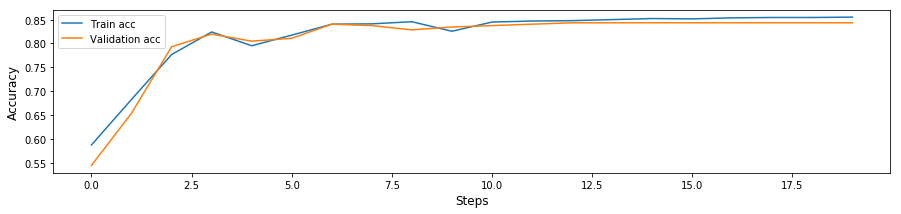

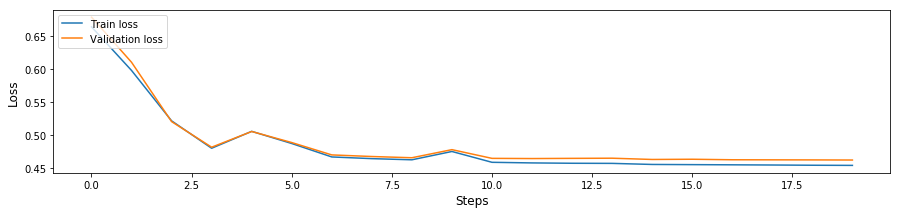

In [202]:
train_acc = [i['acc'] for i in all_train_log]
valid_acc = [i['acc'] for i in all_validate_log]

train_loss = [i['loss'] for i in all_train_log]
valid_loss = [i['loss'] for i in all_validate_log]

plt.figure(figsize=(15, 3))
plt.plot(train_acc)
plt.plot(valid_acc)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Steps', fontsize=12)
plt.legend(['Train acc', 'Validation acc'], fontsize=10, loc='upper left')
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(train_loss)
plt.plot(valid_loss)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Steps', fontsize=12)
plt.legend(['Train loss', 'Validation loss'], fontsize=10, loc='upper left')
plt.show()